
image 1/1 c:\Users\rohan\Desktop\Now\braille\braille_page_output_4.jpg: 224x640 4 As, 1 C, 2 Ds, 7 Es, 1 F, 5 Hs, 2 Is, 2 Ks, 1 L, 9 Ms, 4 Ns, 7 Os, 1 P, 3 Rs, 2 Ss, 1 V, 4 Ys, 139.7ms
Speed: 1.7ms preprocess, 139.7ms inference, 9.4ms postprocess per image at shape (1, 3, 224, 640)


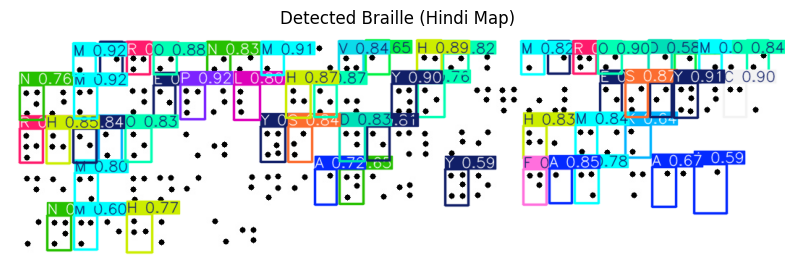

🔤 Detected Classes: MERONMVIHOMERODIMONMEPLHOYOESEYCRHEKOYSDEHMKMANYFAMAANMH
🟤 Braille Output:
 ������������������
��������������
������������
���������
���



In [3]:
# ==========================
# 🔹 SETUP
# ==========================

import os
import json
import numpy as np
import cv2
import urllib.request
from PIL import Image
from ultralytics import YOLO
import matplotlib.pyplot as plt

# ==========================
# 🔹 BRAILLE MAP (YOUR VERSION)
# ==========================
def dots_to_bit(dots):
    """Convert dot positions (1-6) to a 6-bit integer representation."""
    bit = 0
    for d in dots:
        bit |= 1 << (d - 1)
    return bit


# Hindi (Devanagari) Braille map
braille_map = {
    dots_to_bit([1]): 'अ',
    dots_to_bit([3, 4, 5]): 'आ',
    dots_to_bit([2, 4]): 'इ',
    dots_to_bit([3, 5]): 'ई',
    dots_to_bit([1, 3, 6]): 'उ',
    dots_to_bit([1, 2, 5, 6]): 'ऊ',
    dots_to_bit([1, 5, 6]): 'ऋ',
    dots_to_bit([1, 5]): 'ए',
    dots_to_bit([3, 4]): 'ऐ',
    dots_to_bit([1, 3, 5]): 'ओ',
    dots_to_bit([2, 4, 6]): 'औ',
    dots_to_bit([1, 6]): 'अं',
    dots_to_bit([6]): 'अः',

    dots_to_bit([1, 3]): 'क',
    dots_to_bit([4, 6]): 'ख',
    dots_to_bit([1, 2, 4, 5]): 'ग',
    dots_to_bit([1, 2, 6]): 'घ',
    dots_to_bit([3, 4, 6]): 'ङ',
    dots_to_bit([1, 4]): 'च',
    dots_to_bit([1, 6]): 'छ',
    dots_to_bit([2, 4, 5]): 'ज',
    dots_to_bit([3, 5, 6]): 'झ',
    dots_to_bit([2, 5]): 'ञ',
    dots_to_bit([2, 3, 4, 6]): 'ट',
    dots_to_bit([2, 4, 5, 6]): 'ठ',
    dots_to_bit([1, 2, 4, 6]): 'ड',
    dots_to_bit([1, 2, 3, 4, 6]): 'ढ',
    dots_to_bit([3, 4, 5, 6]): 'ण',
    dots_to_bit([2, 3, 4, 5]): 'त',
    dots_to_bit([1, 4, 5, 6]): 'थ',
    dots_to_bit([1, 4, 5]): 'द',
    dots_to_bit([2, 3, 5, 6]): 'ध',
    dots_to_bit([1, 3, 4, 5]): 'न',
    dots_to_bit([1, 2, 3, 4]): 'प',
    dots_to_bit([2, 3, 5]): 'फ',
    dots_to_bit([1, 2]): 'ब',
    dots_to_bit([4, 5]): 'भ',
    dots_to_bit([1, 3, 4]): 'म',
    dots_to_bit([1, 3, 4, 5, 6]): 'य',
    dots_to_bit([1, 2, 3, 5]): 'र',
    dots_to_bit([1, 2, 3]): 'ल',
    dots_to_bit([1, 2, 3, 6]): 'व',
    dots_to_bit([1, 4, 6]): 'श',
    dots_to_bit([1, 2, 3, 4, 6]): 'ष',
    dots_to_bit([2, 3, 4]): 'स',
    dots_to_bit([1, 2, 5]): 'ह',
    dots_to_bit([1, 2, 3, 4, 5]): 'क्ष',
    dots_to_bit([1, 5, 6]): 'ज्ञ',
}

# Compound (multi-cell) Braille patterns
braille_map_compound = {
    (dots_to_bit([5]), dots_to_bit([1, 2, 4, 5, 6])): 'त्र',
}


# ==========================
# 🔹 BRAILLE UTILS CLASS
# ==========================
class BrailleUtils:
    """Handles Braille conversion and detection box parsing."""

    def __init__(self):
        self.braille_map = braille_map
        self.braille_map_compound = braille_map_compound

    def convert_to_braille_unicode(self, key):
        """Return the Braille character for a given class name (or bit pattern)."""
        # Assume YOLO class names are like "dot_1_3" or similar — you can adjust this logic:
        try:
            dots = [int(d) for d in key.replace("dot_", "").split("_") if d.isdigit()]
            bit = dots_to_bit(dots)
            return self.braille_map.get(bit, "�")
        except Exception:
            return "�"

    def parse_xywh_and_class(self, boxes):
        """Group YOLO detections by lines (sorted y, then x)."""
        if boxes is None or len(boxes) == 0:
            return []

        new_boxes = np.zeros((boxes.xywh.shape[0], 6))
        new_boxes[:, :4] = boxes.xywh.cpu().numpy()
        new_boxes[:, 4] = boxes.conf.cpu().numpy()
        new_boxes[:, 5] = boxes.cls.cpu().numpy()

        new_boxes = new_boxes[new_boxes[:, 1].argsort()]
        y_threshold = np.mean(new_boxes[:, 3]) // 2 if len(new_boxes) > 1 else 10
        boxes_diff = np.diff(new_boxes[:, 1])
        threshold_index = np.where(boxes_diff > y_threshold)[0]
        boxes_clustered = np.split(new_boxes, threshold_index + 1)

        boxes_return = []
        for cluster in boxes_clustered:
            cluster = cluster[cluster[:, 0].argsort()]
            boxes_return.append(cluster)
        return boxes_return

    @staticmethod
    def urls_to_image(path_or_url):
        """Load image from URL or local path."""
        try:
            if path_or_url.startswith("http"):
                resp = urllib.request.urlopen(path_or_url)
                arr = np.asarray(bytearray(resp.read()), dtype=np.uint8)
                return cv2.imdecode(arr, cv2.IMREAD_COLOR)
            else:
                return cv2.imread(path_or_url)
        except Exception as e:
            print("Error loading image:", e)
            return None


# ==========================
# 🔹 BRAILLE DETECTION CLASS
# ==========================
class BrailleDetection:
    def __init__(self, model_path, confidence_threshold=0.5):
        self.model = YOLO(model_path)
        self.confidence_threshold = confidence_threshold
        self.utils = BrailleUtils()

    def predict(self, image_path):
        results = self.model.predict(image_path, conf=self.confidence_threshold)
        annotated = results[0].plot()
        return results, annotated

    def process_predictions(self, results):
        boxes = results[0].boxes
        grouped = self.utils.parse_xywh_and_class(boxes)
        detected, braille_output = "", ""

        for line in grouped:
            braille_line = ""
            for each_class in line[:, -1]:
                class_name = self.model.names[int(each_class)]
                detected += class_name
                braille_line += self.utils.convert_to_braille_unicode(class_name)
            braille_output += braille_line + "\n"
        return detected, braille_output

    def run(self, image_path):
        results, annotated = self.predict(image_path)
        detected, braille_output = self.process_predictions(results)
        return annotated, detected, braille_output


# ==========================
# 🔹 RUN DETECTION
# ==========================

# ✅ Change these two paths
IMAGE_PATH = "braille_page_output_4.jpg"   # or r"C:\path\to\your\image.jpg"
MODEL_PATH = "Braille_Yolov11.pt"   # 🔸 Replace with your Braille model URL or local .pt path

detector = BrailleDetection(MODEL_PATH, confidence_threshold=0.5)
annotated_img, detected_classes, braille_text = detector.run(IMAGE_PATH)

# ==========================
# 🔹 DISPLAY RESULTS
# ==========================
if annotated_img is not None:
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Detected Braille (Hindi Map)")
    plt.show()

print("🔤 Detected Classes:", detected_classes)
print("🟤 Braille Output:\n", braille_text)
